In [31]:
import pandas as pd
import numpy as np
import sqlite3
from pprint import pprint
import seaborn as sb
import altair as alt
from multiprocessing import Pool
import folium
from folium import plugins
from folium.plugins import HeatMap
%matplotlib inline
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pygeohash as pgh
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plot_options = dict(figsize=(12,6))
from datetime import datetime
from sklearn import tree, preprocessing
import sklearn.ensemble as ske
import calendar


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression

In [6]:
df = pd.read_csv("Fires.csv")
df.head()


/var/folders/wc/vrt3f8rj2y7gg4f0v_6jvnhh0000gn/T/ipykernel_5082/3385490555.py:1: DtypeWarning: Columns (8,10,11,12,13,14,15,16,17,18,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Fires.csv")


,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63.0,63.0,Plumas,NaN
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61.0,61.0,Placer,NaN
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17.0,17.0,El Dorado,NaN
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3.0,3.0,Alpine,NaN
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3.0,3.0,Alpine,NaN


In [10]:
#subset of data which are useful for cause prediction
subset_df = df[["FIRE_YEAR","STAT_CAUSE_DESCR","LATITUDE","LONGITUDE","STATE","DISCOVERY_DATE","FIRE_SIZE" ]]
print(subset_df.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE  
0       0.10  
1       0.25  
2       0.10  
3       0.10  
4       0.10  


In [13]:
subset_df['DATE'] = pd.to_datetime(subset_df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
print(subset_df.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  
0       0.10 2005-02-02  
1       0.25 2004-05-12  
2       0.10 2004-05-31  
3       0.10 2004-06-28  
4       0.10 2004-06-28  


/var/folders/wc/vrt3f8rj2y7gg4f0v_6jvnhh0000gn/T/ipykernel_5082/2124551077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['DATE'] = pd.to_datetime(subset_df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')


In [40]:
subset_df['MONTH'] = pd.DatetimeIndex(subset_df['DATE']).month
# subset_df['DAY_OF_WEEK'] = pd.DatetimeIndex(subset_df['DATE'])
# subset_df['DAY_OF_WEEK'] = pd.Timestamp(subset_df['DAY_OF_WEEK']).day_name()
subset_df['DAY_OF_WEEK'] = subset_df['DATE'].dt.day_name()
df_orig = subset_df.copy() #I will use this copy later
print(subset_df.head())

/var/folders/wc/vrt3f8rj2y7gg4f0v_6jvnhh0000gn/T/ipykernel_5082/2188630622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['MONTH'] = pd.DatetimeIndex(subset_df['DATE']).month


   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  MONTH DAY_OF_WEEK  
0       0.10 2005-02-02      2   Wednesday  
1       0.25 2004-05-12      5   Wednesday  
2       0.10 2004-05-31      5      Monday  
3       0.10 2004-06-28      6      Monday  
4       0.10 2004-06-28      6      Monday  


/var/folders/wc/vrt3f8rj2y7gg4f0v_6jvnhh0000gn/T/ipykernel_5082/2188630622.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['DAY_OF_WEEK'] = subset_df['DATE'].dt.day_name()


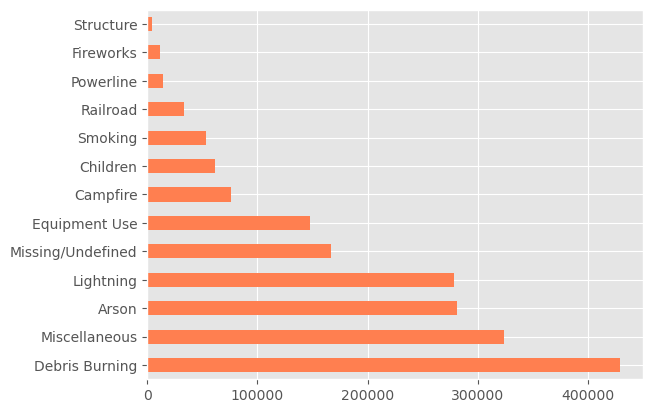

In [41]:
subset_df['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral')
plt.show()

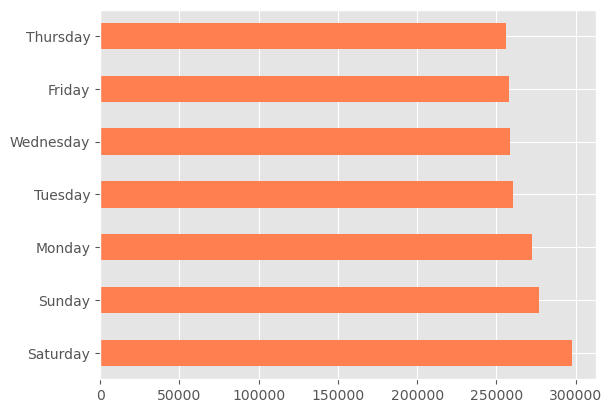

In [43]:
subset_df['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

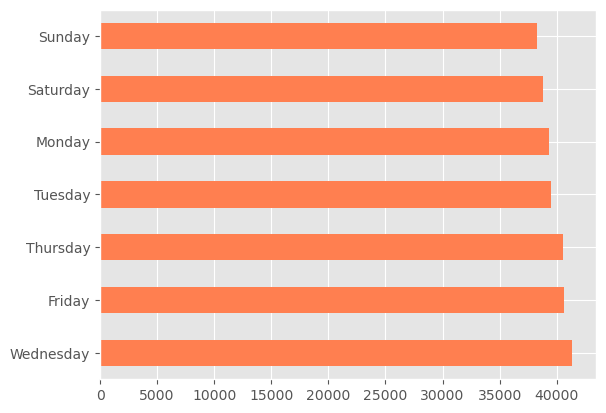

In [44]:
df_lightning = subset_df[subset_df['STAT_CAUSE_DESCR']=='Lightning']
df_lightning['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

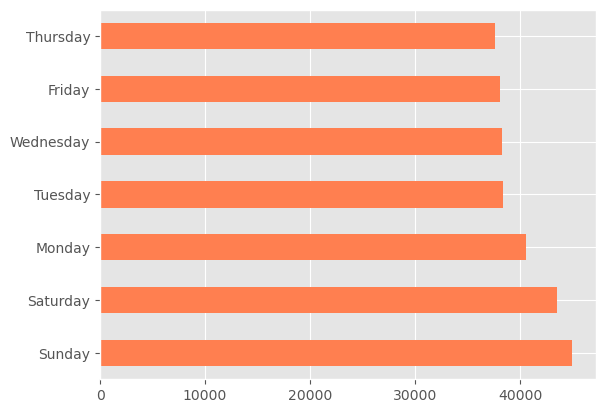

In [46]:
df_arson = subset_df[subset_df['STAT_CAUSE_DESCR']=='Arson']
df_arson['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

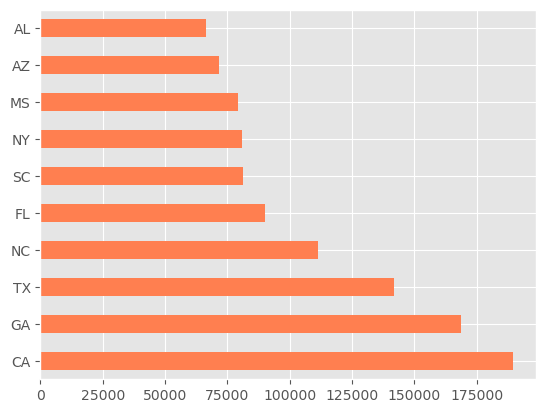

In [52]:
subset_df['STATE'].value_counts().head(n=10).plot(kind='barh',color='coral')
plt.show()

In [48]:
df_CA = subset_df[subset_df['STATE']=='CA']
df_GA = subset_df[subset_df['STATE']=='GA']
df_TX = subset_df[subset_df['STATE']=='TX']

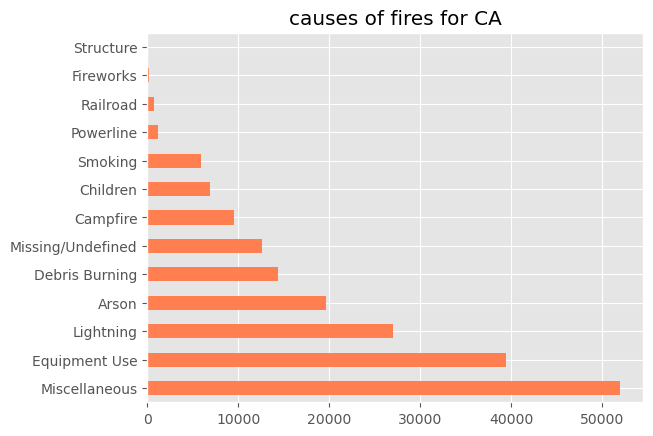

In [49]:
df_CA['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral',title='causes of fires for CA')
plt.show()

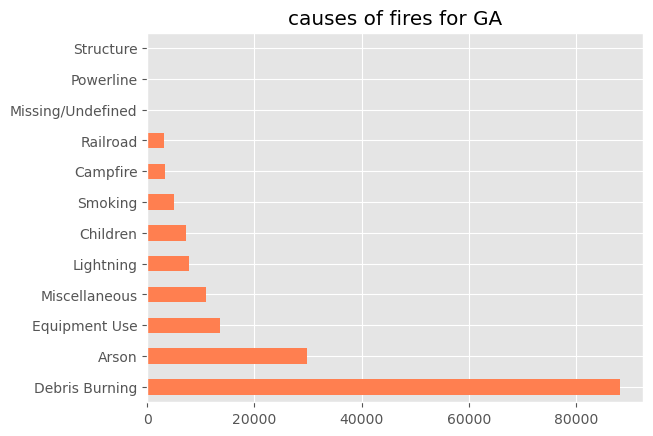

In [50]:
df_GA['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral',title='causes of fires for GA')
plt.show()

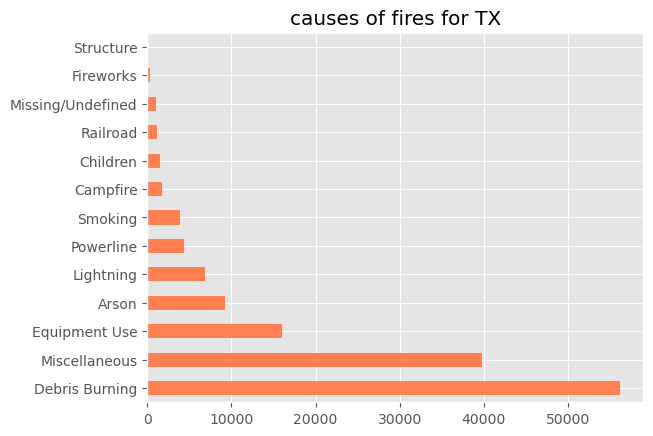

In [51]:
df_TX['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral',title='causes of fires for TX')
plt.show()

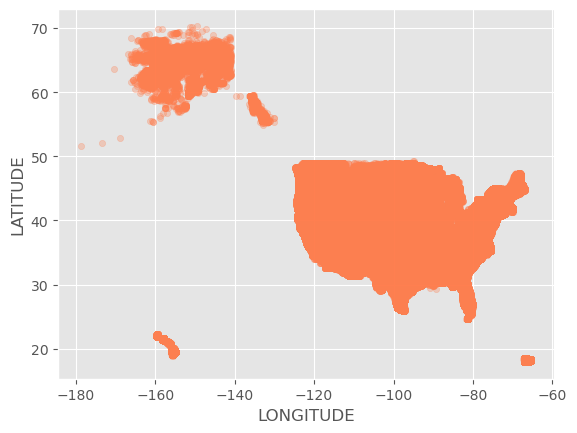

In [53]:
subset_df.plot(kind='scatter',x='LONGITUDE',y='LATITUDE',color='coral',alpha=0.3)
plt.show()

In [54]:
le = preprocessing.LabelEncoder()
subset_df['STAT_CAUSE_DESCR'] = le.fit_transform(subset_df['STAT_CAUSE_DESCR'])
subset_df['STATE'] = le.fit_transform(subset_df['STATE'])
subset_df['DAY_OF_WEEK'] = le.fit_transform(subset_df['DAY_OF_WEEK'])
print(subset_df.head())

/var/folders/wc/vrt3f8rj2y7gg4f0v_6jvnhh0000gn/T/ipykernel_5082/911361700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['STAT_CAUSE_DESCR'] = le.fit_transform(subset_df['STAT_CAUSE_DESCR'])
/var/folders/wc/vrt3f8rj2y7gg4f0v_6jvnhh0000gn/T/ipykernel_5082/911361700.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['STATE'] = le.fit_transform(subset_df['STATE'])


   FIRE_YEAR  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE  STATE  DISCOVERY_DATE  \
0       2005                 7  40.036944 -121.005833      4       2453403.5   
1       2004                 6  38.933056 -120.404444      4       2453137.5   
2       2004                 3  38.984167 -120.735556      4       2453156.5   
3       2004                 6  38.559167 -119.913333      4       2453184.5   
4       2004                 6  38.559167 -119.933056      4       2453184.5   

   FIRE_SIZE       DATE  MONTH  DAY_OF_WEEK  
0       0.10 2005-02-02      2            6  
1       0.25 2004-05-12      5            6  
2       0.10 2004-05-31      5            1  
3       0.10 2004-06-28      6            1  
4       0.10 2004-06-28      6            1  


/var/folders/wc/vrt3f8rj2y7gg4f0v_6jvnhh0000gn/T/ipykernel_5082/911361700.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['DAY_OF_WEEK'] = le.fit_transform(subset_df['DAY_OF_WEEK'])
